Goal: detect bounding boxes (!) delineating the nodes at the root of a plant. Below is one way to read the data
(probably not convenient for your approach and not the best way but it
demonstrates how to interpret the data in the json file)

In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
import random
from PIL import Image
from matplotlib import cm
from IPython.display import display

In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
print(torch.cuda.is_available())

False


In [3]:
class MyData(Dataset):
    def __init__(self):
        file = 'data.json'
        f = open(file)
        self.data = json.load(f)
        f.close()
        resh = 500
        resw = 500
        self.imgs = []
        self.gts = []
        self.nums = []
        self.imgsPIL = []
        self.imgsRaw = []
        for key,val in self.data.items():
            try:
                imgPIL = Image.open(val['filename'])
                origwidth = imgPIL.size[0]
                origheight = imgPIL.size[1]
                imgPIL = imgPIL.resize((resw,resh),Image.LANCZOS)
                image = torch.Tensor(np.asarray(imgPIL)/255)
                gt = torch.zeros((image.shape[0:2]))
                for k2,v2 in val['regions'].items():
                    rectdata = v2['shape_attributes']
                    x1 = int(np.floor(resw*float(rectdata['x'])/origwidth))
                    y1 = int(np.floor(resh*float(rectdata['y'])/origheight))
                    x2 = int(np.ceil(resw*float(rectdata['x']+rectdata['width'])/origwidth))
                    y2 = int(np.ceil(resh*float(rectdata['y']+rectdata['height'])/origheight))
                    gt[y1:y2,x1:x2] = 1
                print('File: {}; number: {}'.format(val['filename'],len(val['regions'])))
                gtimg = Image.fromarray(np.uint8(cm.gist_earth(gt.numpy())*255))
                self.imgsRaw.append(imgPIL)
                self.imgsPIL.append(Image.blend(imgPIL.convert("RGBA"),gtimg.convert("RGBA"),0.5))
                self.imgs.append(image.permute(2,0,1))
                self.gts.append(gt)
                self.nums.append(len(val['regions']))
            except IOError:
                print('File not found: {}'.format(val['filename']))
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self,idx):
        d,g = self.imgs[idx], self.gts[idx].unsqueeze(0)
        return d, g, idx

In [4]:
data = MyData()

File: 005-9-01.jpg; number: 276
File: 022-5-02.jpg; number: 10
File: 22-14-01.jpg; number: 261
File: W005-4-05.jpg; number: 133
File: W005-08-03.jpg; number: 426
File: W005-08-04.jpg; number: 271
File: W005-08-06.jpg; number: 199
File: W005-14-02.jpg; number: 18
File not found: W022-02-07.jpg
File: W022-04-04.jpg; number: 237
File: W022-07-03.jpg; number: 280
File not found: W022-16-05.jpg
File not found: W022-19-06.jpg
File not found: W035-11-05.jpg
File not found: W035-18-03.jpg
File not found: W035-19-06.jpg
File not found: W035-19-07.jpg
File not found: W035-20-02.jpg


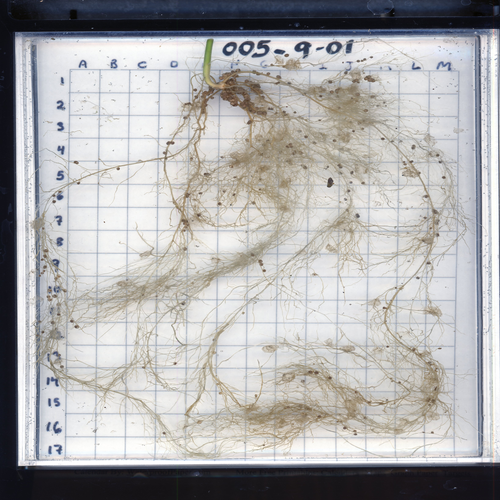

In [5]:
display(data.imgsRaw[0])

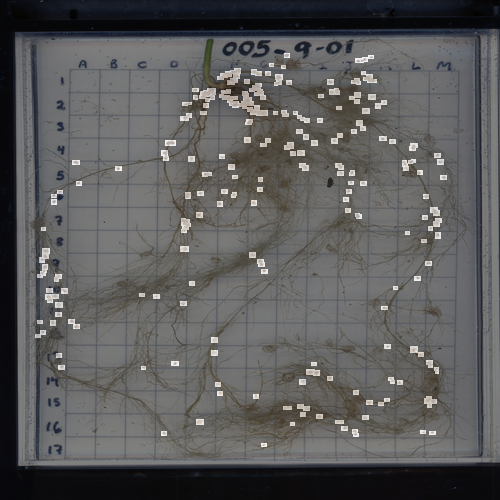

In [6]:
display(data.imgsPIL[0])